In [11]:
import zipfile
import os
zip_files = {
    "Bacterial leaf blight": "Bacterial leaf blight-20200814T055237Z-001.zip",
    "Brown spot": "Brown spot-20200814T055208Z-001.zip",
    "Leaf smut": "Leaf smut-20200814T055530Z-001.zip"
}
extracted_dirs = {}
for disease, zip_name in zip_files.items():
    extract_path = f"./{disease.replace(' ', '_')}"
    os.makedirs(extract_path, exist_ok=True)
    with zipfile.ZipFile(zip_name, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    extracted_dirs[disease] = os.path.join(extract_path, disease)

In [15]:
image_counts = {}
for disease, folder_path in extracted_dirs.items():
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    image_counts[disease] = len(image_files)
image_counts

{'Bacterial leaf blight': 40, 'Brown spot': 40, 'Leaf smut': 39}

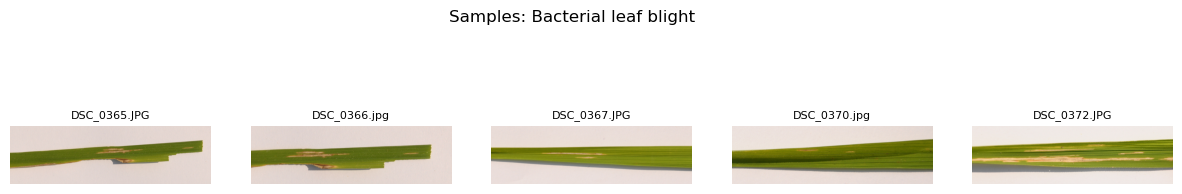

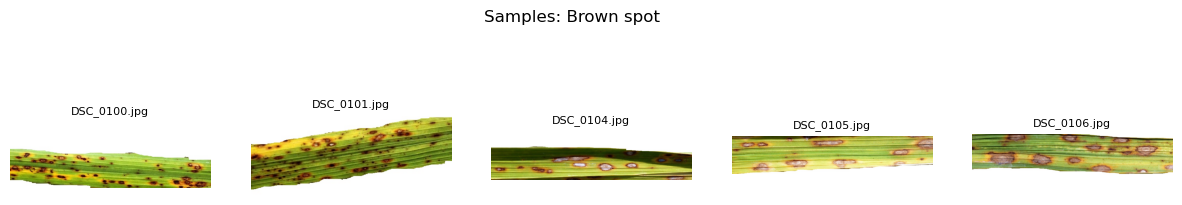

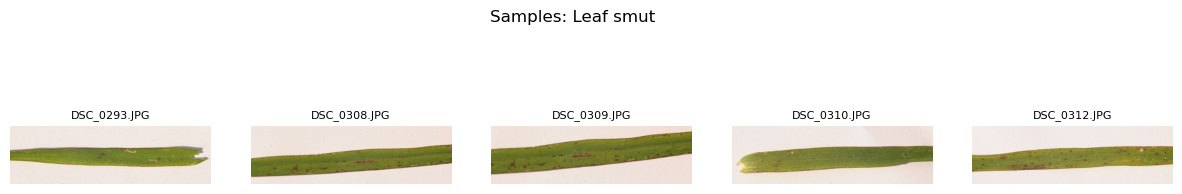

In [17]:
import matplotlib.pyplot as plt
from PIL import Image

# Function to plot sample images
def show_samples(folder_path, title, n=5):
    files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))][:n]
    plt.figure(figsize=(15, 3))
    for i, file in enumerate(files):
        img = Image.open(os.path.join(folder_path, file))
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.title(file, fontsize=8)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Show samples from each class
for disease, folder_path in extracted_dirs.items():
    show_samples(folder_path, f"Samples: {disease}")


In [19]:
from PIL import Image, UnidentifiedImageError
from collections import Counter
import matplotlib.pyplot as plt

# Store all image sizes and errors
image_sizes = []
corrupt_images = []

# Loop through all disease folders
for disease, folder_path in extracted_dirs.items():
    print(f"🔍 Checking: {disease}")
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        try:
            with Image.open(file_path) as img:
                image_sizes.append(img.size)  # (width, height)
        except UnidentifiedImageError:
            corrupt_images.append(file_path)

# Show basic statistics
print(f"\n✅ Total images processed: {len(image_sizes)}")
print(f"❌ Corrupt or unreadable images: {len(corrupt_images)}")
if corrupt_images:
    print("⚠️ Corrupt Files:")
    for f in corrupt_images:
        print(f"  - {f}")


🔍 Checking: Bacterial leaf blight
🔍 Checking: Brown spot
🔍 Checking: Leaf smut

✅ Total images processed: 119
❌ Corrupt or unreadable images: 0


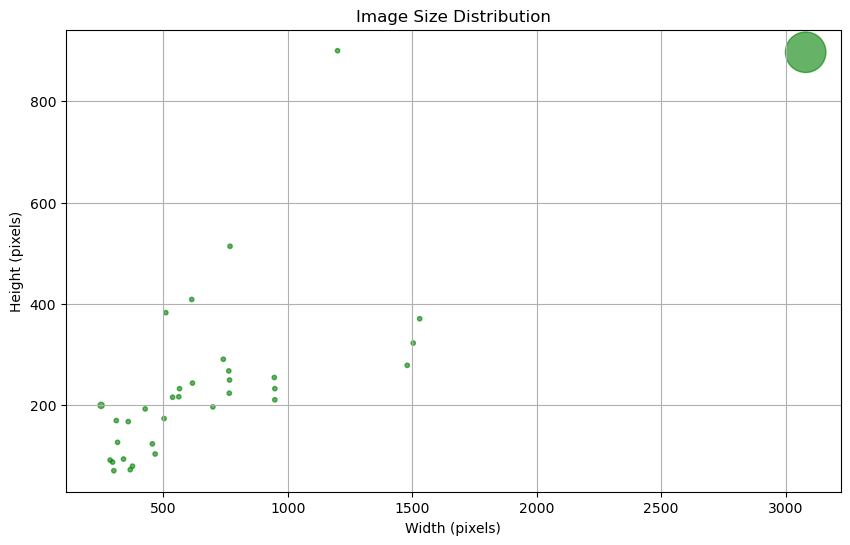

In [23]:
import numpy as np  # ✅ Add this if not already done

# Count how many times each size appears
from collections import Counter
size_counter = Counter(image_sizes)
sizes, counts = zip(*size_counter.items())

# Convert to numpy array for plotting
widths, heights = zip(*sizes)

plt.figure(figsize=(10, 6))
plt.scatter(widths, heights, s=np.array(counts)*10, alpha=0.6, c='green')
plt.title("Image Size Distribution")
plt.xlabel("Width (pixels)")
plt.ylabel("Height (pixels)")
plt.grid(True)
plt.show()


In [27]:
TARGET_SIZE = (224, 224)

# Resize and overwrite all images
for disease, folder_path in extracted_dirs.items():
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        try:
            with Image.open(file_path) as img:
                img = img.resize(TARGET_SIZE)
                img.save(file_path)
        except:
            continue  # Skip if unreadable


In [29]:
import os
import random
import shutil

def split_data(source_dir, dest_dir, split_ratios=(0.7, 0.15, 0.15)):
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    classes = list(source_dir.keys())
    
    for cls in classes:
        files = os.listdir(source_dir[cls])
        files = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        random.shuffle(files)

        total = len(files)
        train_end = int(split_ratios[0] * total)
        val_end = train_end + int(split_ratios[1] * total)

        splits = {
            'train': files[:train_end],
            'val': files[train_end:val_end],
            'test': files[val_end:]
        }

        for split_name, split_files in splits.items():
            split_folder = os.path.join(dest_dir, split_name, cls.lower().replace(" ", "_"))
            os.makedirs(split_folder, exist_ok=True)

            for file in split_files:
                src = os.path.join(source_dir[cls], file)
                dst = os.path.join(split_folder, file)
                shutil.copy2(src, dst)

# Source directories from previous extractions
source_dirs = extracted_dirs  # already in dict format: {label: path}

# Output base directory
output_base = "./dataset"
split_data(source_dirs, output_base)
print("✅ Dataset split into train/val/test and organized.")


✅ Dataset split into train/val/test and organized.


In [31]:
# Check number of images in each split
for split in ['train', 'val', 'test']:
    print(f"\n📁 {split.upper()}")
    for cls in os.listdir(f"{output_base}/{split}"):
        count = len(os.listdir(f"{output_base}/{split}/{cls}"))
        print(f"  - {cls}: {count} images")



📁 TRAIN
  - bacterial_leaf_blight: 28 images
  - brown_spot: 28 images
  - leaf_smut: 27 images

📁 VAL
  - bacterial_leaf_blight: 6 images
  - brown_spot: 6 images
  - leaf_smut: 5 images

📁 TEST
  - bacterial_leaf_blight: 6 images
  - brown_spot: 6 images
  - leaf_smut: 7 images


In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
train_dir = './dataset/train'
val_dir = './dataset/val'
test_dir = './dataset/test'

# Image size and batch
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data generators with basic normalization
train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

# Create generators
train_data = train_gen.flow_from_directory(train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
val_data = val_gen.flow_from_directory(val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
test_data = test_gen.flow_from_directory(test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)


Found 83 images belonging to 3 classes.
Found 17 images belonging to 3 classes.
Found 19 images belonging to 3 classes.


In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')  # 3 classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


C:\Users\HP\AppData\Local\Programs\Orange\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,907,779 (91.20 MB)

 Trainable params: 23,907,779 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=[early_stop]
)


C:\Users\HP\AppData\Local\Programs\Orange\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 542ms/step - accuracy: 0.3620 - loss: 4.9197 - val_accuracy: 0.2941 - val_loss: 14.5450
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 337ms/step - accuracy: 0.2974 - loss: 11.9989 - val_accuracy: 0.3529 - val_loss: 2.1793
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.3754 - loss: 2.3343 - val_accuracy: 0.3529 - val_loss: 1.5526
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 352ms/step - accuracy: 0.4001 - loss: 1.3203 - val_accuracy: 0.4706 - val_loss: 1.0349
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 354ms/step - accuracy: 0.4620 - loss: 0.9958 - val_accuracy: 0.6471 - val_loss: 0.9428
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step - accuracy: 0.5788 - loss: 0.9497 - val_accuracy: 0.5294 - val_loss: 0.9964
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 383ms/step - accuracy: 0.6288 - loss: 0.8166 - val_accuracy: 0.7059 - val_loss: 0.7643
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 372ms/step - accuracy: 0.6122 - loss: 0.9312 - val_accuracy: 0.5882 - val_los

In [39]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_data)
print(f"✅ Test Accuracy: {test_acc:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8421 - loss: 0.5832
✅ Test Accuracy: 0.84


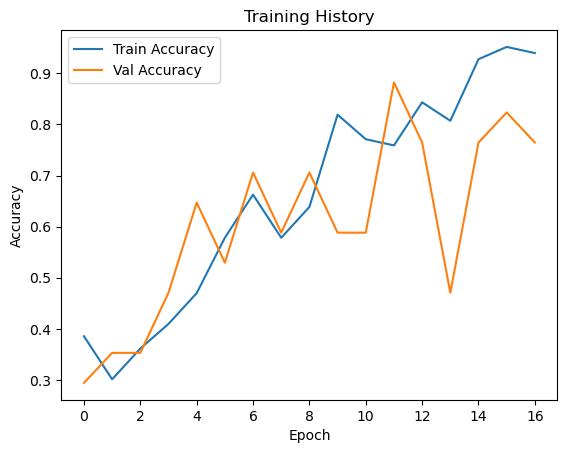

In [41]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Training History")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [43]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmented data generator for training
augmented_train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    shear_range=0.15,
    fill_mode='nearest'
)

# Use same validation and test generators as before
train_aug_data = augmented_train_gen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 83 images belonging to 3 classes.


In [45]:
# Re-initialize the model
model_aug = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')  # 3 classes
])

model_aug.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train with augmented data
history_aug = model_aug.fit(
    train_aug_data,
    validation_data=val_data,
    epochs=20,
    callbacks=[early_stop]
)


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 738ms/step - accuracy: 0.3332 - loss: 15.1139 - val_accuracy: 0.3529 - val_loss: 8.9523
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 572ms/step - accuracy: 0.3347 - loss: 5.2373 - val_accuracy: 0.2941 - val_loss: 2.6811
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 583ms/step - accuracy: 0.3731 - loss: 2.7702 - val_accuracy: 0.3529 - val_loss: 1.1317
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 442ms/step - accuracy: 0.3033 - loss: 1.3981 - val_accuracy: 0.3529 - val_loss: 1.1675
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 651ms/step - accuracy: 0.3359 - loss: 1.2135 - val_accuracy: 0.2941 - val_loss: 1.1843
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 517ms/step - accuracy: 0.3605 - loss: 1.1479 - val_accuracy: 0.2941 - val_loss: 1.1095
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 488ms/step - accuracy: 0.2472 - loss: 1.1101 - val_accuracy: 0.2941 - val_loss: 1.1131
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 469ms/step - accuracy: 0.2907 - loss: 1.1048 - val_accuracy: 0.5294 - val_loss

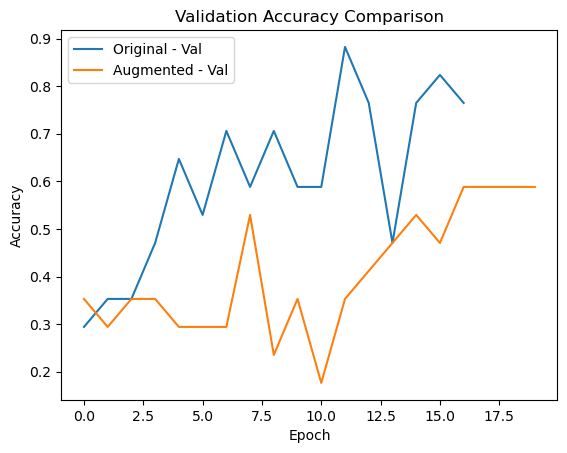

In [47]:
# Plot side-by-side comparison
plt.plot(history.history['val_accuracy'], label='Original - Val')
plt.plot(history_aug.history['val_accuracy'], label='Augmented - Val')
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


 ***Model Comparison Report: Rice Leaf Disease Classification***

***Performance Summary***

***Recomendation***

***Challenges Faced***